# Initialize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyltr
!pip install tqdm

In [ ]:
import pyltr
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

## Data proccessing

For preprocessing, we have compared each pair of documents with the same query and created one new sample for each pair. We store new data in a file so we don't have to reproduce it repeatedly. When initializing `Data` class, it will first check for preprocessed data in the file and try to load it. If it does not exist, it will use raw data to generate new data pairs and store them in a file.

In [ ]:
class Data:
  def __init__(self, unprocessed_dir_path, processed_dir_path, name='data', force_load=False):
    self.name = name
    self.unprocessed_dir_path = unprocessed_dir_path
    self.processed_dir_path = processed_dir_path

    self.train_X = None
    self.train_y = None

    self.valid_X = None
    self.valid_y = None
    
    self.valid_X = None
    self.valid_y = None

    try:
      if force_load:
        raise FileNotFoundError

      self.load_processed()
      print("Proccessed data already exist, data loaded.")
    except FileNotFoundError:
      self.load_and_process() 
      self.save_processed()
      print("Proccessed data does not exist, unprocessed data loaded and saved.")    

    print("train_shape:", self.train_X.shape, self.train_y.shape)
    print("test_shape:", self.test_X.shape, self.test_y.shape)
    print("valid_shape:", self.valid_X.shape, self.valid_y.shape)

               
  def _read_data(self, data_path):
    """
      Read X, y, and qids from `datapath`
    """
    with open(data_path) as f:
      X, y, qids, _ = pyltr.data.letor.read_dataset(f)
    
    print(f"Data in {data_path} loaded.")
    return X, y, qids

  def _load_directory(self, base_path):
    """
      Load train, test, and validation data from `base_path` directory.
      Return three tuples for each of train, test, and validation, where 
      each tuple has format of (X, y, qid)
    """
    train_path = os.path.join(base_path, "train.txt")
    test_path = os.path.join(base_path, "test.txt") 
    valid_path = os.path.join(base_path, "vali.txt")

    train_X, train_y, train_q = self._read_data(train_path)
    valid_X, valid_y, valid_q = self._read_data(valid_path)   
    test_X, test_y, test_q = self._read_data(test_path)

    return (train_X, train_y, train_q), (valid_X, valid_y, valid_q), (test_X, test_y, test_q)

  def _separate_indexes_with_same_value(self, arr):  
    """
    arr: np.ndarray

    Return an array of arrays where each array contains indexes of same value.
    e.g. 
    input:  arr = [1, 1, 1, 3, 3, 8, 10, 10]
    output: [[0, 1, 2], [3, 4], [5], [6, 7]]
    """

    idx_sort = np.argsort(arr, kind='mergesort')
    arr = arr[idx_sort]
    
    vals, idx_start = np.unique(arr, return_counts=False, return_index=True)

    separated_indexes = np.asarray(np.split(idx_sort, idx_start[1:]), dtype=np.ndarray).reshape(len(vals), 1)

    pair_indexes = np.empty([0,2], dtype=int)

    for indexes in separated_indexes:
      p = np.vstack(np.triu_indices(len(indexes[0]), k=1)).T + indexes[0][0]
      pair_indexes = np.concatenate((pair_indexes, p), axis=0)
    
    print(f"Pair indexes generated.")
    return pair_indexes

  def _generate_data_pairs(self, X, y, pair_indexes):
    """
    pair_indexes: array of pairs

    Generate pairs of samples where indexes of pairs is contained in `pair_indexes`.
    """
    def generate_x_pair(row):
      ind = row
      return X[ind[0]] - X[ind[1]]

    def generate_y_pair(row):
      ind = row
      return 1 if y[ind[0]] >= y[ind[1]] else 0

    new_X = np.apply_along_axis(generate_x_pair, 1, pair_indexes)
    new_y = np.apply_along_axis(generate_y_pair, 1, pair_indexes)
    return new_X, new_y

  def load_and_process(self):
    """
    Load each of train, validation, and test dataset and generate pair of samples.
    """
    train, valid, test = self._load_directory(self.unprocessed_dir_path)
    
    pair_indexes = self._separate_indexes_with_same_value(train[2])
    self.train_X, self.train_y = self._generate_data_pairs(train[0], train[1], pair_indexes)
    print(f"Train data processing finished.")

    pair_indexes = self._separate_indexes_with_same_value(test[2])
    self.test_X, self.test_y = self._generate_data_pairs(test[0], test[1], pair_indexes)
    print(f"Test data processing finished.")

    pair_indexes = self._separate_indexes_with_same_value(valid[2])
    self.valid_X, self.valid_y = self._generate_data_pairs(valid[0], valid[1], pair_indexes)
    print(f"Validation data processing finished.")

  def save_processed(self):
    """
    Save processed data to file
    """
    data_in_pairs_path = f'{self.processed_dir_path}/{self.name}.npz'
    np.savez(data_in_pairs_path, train_x=self.train_X, train_y=self.train_y,
                                  test_x=self.test_X, test_y=self.test_y,
                                  valid_x=self.valid_X, valid_y=self.valid_y)
    
  def load_processed(self):
    """
    Load processed data from file
    """
    data_in_pairs_path = f'{self.processed_dir_path}/{self.name}.npz'
    npzfile = np.load(data_in_pairs_path)

    self.train_X = npzfile['train_x']
    self.train_y = npzfile['train_y']
    self.test_X = npzfile['test_x']
    self.test_y = npzfile['test_y']
    self.valid_X = npzfile['valid_x']
    self.valid_y = npzfile['valid_y']

In [ ]:
data_folds = []
for i in range(1, 6):
  print(f"~~ Loading fold {i} ...")
  data = Data(unprocessed_dir_path=f"MQ2007/Fold{i}/", processed_dir_path="data_in_pairs", name=f"fold{i}", force_load=False)
  print(f"~~ Fold {i} loaded.")
  data_folds.append(data)

## Common Functions

### Confusion matrix

In [ ]:
def plot_cm(cm):
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center')
  plt.show()

## Logistic Regression model using Sklearn library

`LogisticRegression` class from sklearn library is used for logistic regression. We first trained the model using equal weights for classes (`model_1`.) As the data is skewed and the number of samples with label 1 is much greater than samples with label 0, this model results in low precision and recall for '0' class. Still, the overall accuracy is good (0.86). 

We trained two other models with different weights assigned to the classes base on the number of samples in each class(`model_2` and `model_3`.) These models result in lower accuracy but better f1 score for class with '0' class.

For finding the proper regularization parameter, cross-validation is used.

Confusion matrix, recall, precision, f1 score, and accuracy are calculated for each model and can be viewed in the "Evaluation" section.

### Training

In [ ]:
def cross_validation(model, data, Cs, metric, **model_kwargs):
  best_acc = None
  best_c = None
  best_model = None


  for c in Cs:
    model = LogisticRegression(C=c, **model_kwargs)
    model.fit(data.train_X, data.train_y)

    # calculate metric on validation data
    y_pred = model.predict(data.valid_X)
    val = metric(data.valid_y, y_pred)
    print(f"Metric value for c={c} is {val}")
    if best_acc is None or val > best_acc:
      best_acc = val
      best_c = c
      best_model = model

  return best_c, best_model

In [ ]:
fold_idx = 0

In [ ]:
zeros_count = data_folds[fold_idx].train_y[data_folds[fold_idx].train_y == 0].shape[0]
ones_count = data_folds[fold_idx].train_y.shape[0] - zeros_count
one_to_zero_ratio = ones_count / zeros_count
print("zeros count:", zeros_count)
print("ones count:", ones_count)

zeros count: 125033
ones count: 758813


In [ ]:
model_1_class_weight = {0: 1, 1: 1}
print("model_1 class weight:", model_1_class_weight)
c, model_1 = cross_validation(LogisticRegression, 
                            data_folds[fold_idx], 
                            Cs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 10],
                            metric=accuracy_score,
                            solver = 'liblinear',
                            max_iter = 200,
                            penalty='l2',
                            class_weight=model_1_class_weight)

model_1 class weight: {0: 1, 1: 1}
Metric value for c=1e-06 is 0.8623187886004491
Metric value for c=1e-05 is 0.8623474811525799
Metric value for c=0.0001 is 0.8623438945835634
Metric value for c=0.001 is 0.8623690005666779
Metric value for c=0.01 is 0.8623152020314326
Metric value for c=0.1 is 0.8622614034961875
Metric value for c=1.0 is 0.8622721632032365
Metric value for c=10 is 0.8622757497722529


In [ ]:
model_2_class_weight = {0: one_to_zero_ratio/2, 1: 1}
print("model 2 class weight:", model_2_class_weight)
c, model_2 = cross_validation(LogisticRegression, 
                            data_folds[fold_idx], 
                            Cs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 10],
                            metric=accuracy_score,
                            solver = 'liblinear',
                            max_iter = 200,
                            penalty='l2',
                            class_weight=model_2_class_weight)

model 2 class weight: {0: 3.03445090496109, 1: 1}
Metric value for c=1e-06 is 0.8475672302362114
Metric value for c=1e-05 is 0.842589072441521
Metric value for c=0.0001 is 0.8281746515648201
Metric value for c=0.001 is 0.8175548207074149
Metric value for c=0.01 is 0.8152522433989198
Metric value for c=0.1 is 0.8152092045707235
Metric value for c=1.0 is 0.8152378971228543
Metric value for c=10 is 0.8152486568299033


In [ ]:
model_3_class_weight = {0: one_to_zero_ratio*2/3, 1: 1}
print("model 3 class weight:", model_3_class_weight)
c, model_3 = cross_validation(LogisticRegression, 
                            data_folds[fold_idx], 
                            Cs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 10],
                            metric=accuracy_score,
                            solver = 'liblinear',
                            max_iter = 200,
                            penalty='l2',
                            class_weight=model_3_class_weight)

model 3 class weight: {0: 4.04593453994812, 1: 1}
Metric value for c=1e-06 is 0.806339619393296
Metric value for c=1e-05 is 0.7968746637591547
Metric value for c=0.0001 is 0.7806382658221492
Metric value for c=0.001 is 0.7712593878444003
Metric value for c=0.01 is 0.7689890896570523
Metric value for c=0.1 is 0.7685084894088617
Metric value for c=1.0 is 0.7685766342201723
Metric value for c=10 is 0.7685658745131233


### Evaluation

In [ ]:
def evaluate(model, X, y):
    print("accuracy:", model.score(X, y))

    # predict labels for test data
    pred = model.predict(X)

    # show confusion matrix
    cm = confusion_matrix(y, pred)
    plot_cm(cm)

    # print precision, recall, and f1-score
    print(classification_report(y, pred))

~~~~~~~~~~ MODEL1 (with equal weights for classes) ~~~~~~~~~~
class weight: {0: 1, 1: 1}
train data:
accuracy: 0.8585002364665337


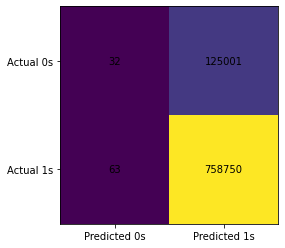

              precision    recall  f1-score   support

           0       0.34      0.00      0.00    125033
           1       0.86      1.00      0.92    758813

    accuracy                           0.86    883846
   macro avg       0.60      0.50      0.46    883846
weighted avg       0.78      0.86      0.79    883846

test data:
accuracy: 0.8585002364665337


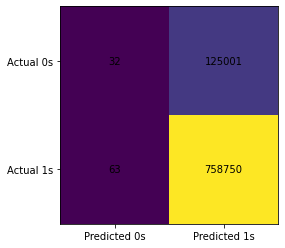

              precision    recall  f1-score   support

           0       0.34      0.00      0.00    125033
           1       0.86      1.00      0.92    758813

    accuracy                           0.86    883846
   macro avg       0.60      0.50      0.46    883846
weighted avg       0.78      0.86      0.79    883846

~~~~~~~~~~ MODEL2 (with different weights for classes) ~~~~~~~~~~
class weight: {0: 3.03445090496109, 1: 1}
train data:
accuracy: 0.8464200777058447


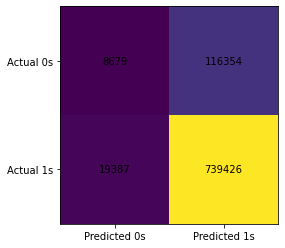

              precision    recall  f1-score   support

           0       0.31      0.07      0.11    125033
           1       0.86      0.97      0.92    758813

    accuracy                           0.85    883846
   macro avg       0.59      0.52      0.51    883846
weighted avg       0.79      0.85      0.80    883846

test data:
accuracy: 0.8464200777058447


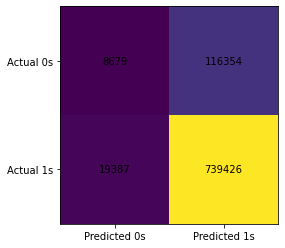

              precision    recall  f1-score   support

           0       0.31      0.07      0.11    125033
           1       0.86      0.97      0.92    758813

    accuracy                           0.85    883846
   macro avg       0.59      0.52      0.51    883846
weighted avg       0.79      0.85      0.80    883846

~~~~~~~~~~ MODEL3 (with different weights for classes) ~~~~~~~~~~
class weight: {0: 4.04593453994812, 1: 1}
train data:
accuracy: 0.8063701142506726


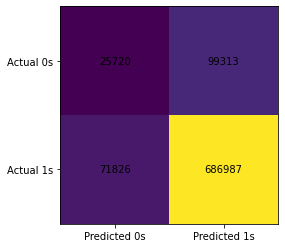

              precision    recall  f1-score   support

           0       0.26      0.21      0.23    125033
           1       0.87      0.91      0.89    758813

    accuracy                           0.81    883846
   macro avg       0.57      0.56      0.56    883846
weighted avg       0.79      0.81      0.80    883846

test data:
accuracy: 0.8063701142506726


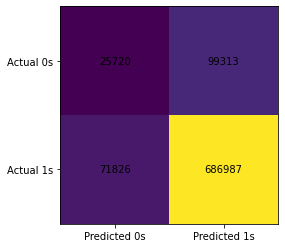

              precision    recall  f1-score   support

           0       0.26      0.21      0.23    125033
           1       0.87      0.91      0.89    758813

    accuracy                           0.81    883846
   macro avg       0.57      0.56      0.56    883846
weighted avg       0.79      0.81      0.80    883846



In [ ]:
print("~~~~~~~~~~ MODEL1 (with equal weights for classes) ~~~~~~~~~~")
print("class weight:", model_1_class_weight)
print("train data:")
evaluate(model_1, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)
print("test data:")
evaluate(model_1, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)

print("~~~~~~~~~~ MODEL2 (with different weights for classes) ~~~~~~~~~~")
print("class weight:", model_2_class_weight)
print("train data:")
evaluate(model_2, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)
print("test data:")
evaluate(model_2, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)


print("~~~~~~~~~~ MODEL3 (with different weights for classes) ~~~~~~~~~~")
print("class weight:", model_3_class_weight)
print("train data:")
evaluate(model_3, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)
print("test data:")
evaluate(model_3, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)

## From-scratch Logistic regression with gradient descent

In this section, we trained a simple logistic regression model from scratch using Gradient Descent. 
The function used for predicting value is of form:

$$y = \sigma(Xw + b)$$

For handling the bias part, we have added a new feature to each sample.

Cross-entropy loss function is used for defining cost funtion:

$$ J = -\frac{1}{n} \Sigma_{i=1}^{N} \Big[ y * log(\sigma(Xw)) +(1-y) * log(1-\sigma(Xw)) \Big] $$

And the update step for w will be:

$$ w_{t+1} = w_{t} + \frac{∂ J}{∂ w_{t}} $$

$$ = w_{t} + (w_{t}x_i-y_i)x_i $$

The vector form of this equation in used in the code.


We have achieved accuracy of 85% on the test data.

### Training

In [ ]:
def sigmoid(A):
   return 1 / ( 1 + np.exp(-A))
   
   
class logistic_regression:
  def __init__(self, threshold = 0.5):
    self.w = None
    self.threshold = threshold

  def fit(self, X, y,  epochs=50, learning_rate = 0.1, print_cost=True, plot_cost=True,):
    y = np.reshape(y, (len(y), 1)) 
    X = np.append(X, np.ones((len(X),1)), axis=1)

    self.w = np.random.randn(X.shape[1], 1)
    self.b = 0

    costs = []
    for epoch in range(epochs):
      z = X.dot(self.w)
      h = sigmoid(z)

      cost = np.sum(- y * np.log(h) - (1-y) * np.log(1-h)) / y.shape[0]

      dw = np.dot(X.T, (h - y)) / y.shape[0]

      self.w = self.w - dw * learning_rate

      if print_cost and epoch % 10 == 0:
        print("epoch:", epoch, "cost:", cost)
      costs.append(cost)

    return costs

  def decision_function(self, X):
      z = X.dot(self.w)
      h = sigmoid(z)
      return h

  def predict(self, X):
      X = np.append(X, np.ones((len(X),1)), axis=1)
      scores = self.decision_function(X)
      preds = 1 * (scores >= self.threshold)
      return preds

In [ ]:
my_model = logistic_regression()

epoch: 0 cost: 1.6975163906540331
epoch: 10 cost: 0.6892848991016604
epoch: 20 cost: 0.5201668866536994
epoch: 30 cost: 0.4785858786967954
epoch: 40 cost: 0.4609832688981275
epoch: 50 cost: 0.44999766724828905
epoch: 60 cost: 0.44171522524800894
epoch: 70 cost: 0.4349907188641216
epoch: 80 cost: 0.4293716595992184
epoch: 90 cost: 0.42461610302855785
epoch: 100 cost: 0.4205631658420597
epoch: 110 cost: 0.4170922369822367
epoch: 120 cost: 0.41410746411211147
epoch: 130 cost: 0.41153055318950454
epoch: 140 cost: 0.40929675137448085
epoch: 150 cost: 0.40735223187539915
epoch: 160 cost: 0.4056521795788066
epoch: 170 cost: 0.40415927665863494
epoch: 180 cost: 0.40284245214484216
epoch: 190 cost: 0.4016758303529271
epoch: 200 cost: 0.4006378431859304
epoch: 210 cost: 0.3997104834105372
epoch: 220 cost: 0.3988786805721727
epoch: 230 cost: 0.39812978305757674
epoch: 240 cost: 0.3974531309804929
epoch: 250 cost: 0.3968397057841511
epoch: 260 cost: 0.39628184387237686
epoch: 270 cost: 0.395773003

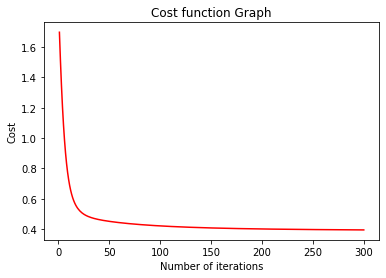

In [ ]:
fold_idx = 0
learning_rate = 0.5
epochs = 300

costs = my_model.fit(data_folds[fold_idx].train_X, 
                     data_folds[fold_idx].train_y,
                     learning_rate=learning_rate,
                     epochs=epochs)

plt.plot(range(1, epochs+1),costs, color = 'red')
plt.title('Cost function Graph')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.show()

### Evaluation

In [ ]:
def evaluate(model, X, y):
    # predict labels for test data
    pred = model.predict(X)

    # show confusion matrix
    cm = confusion_matrix(y, pred)
    plot_cm(cm)

    # print precision, recall, and f1-score
    print(classification_report(y, pred))

Result on train data:


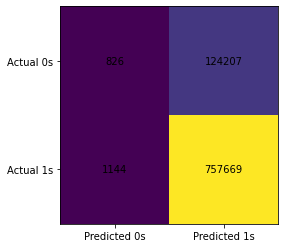

              precision    recall  f1-score   support

           0       0.42      0.01      0.01    125033
           1       0.86      1.00      0.92    758813

    accuracy                           0.86    883846
   macro avg       0.64      0.50      0.47    883846
weighted avg       0.80      0.86      0.79    883846

Result on test data:


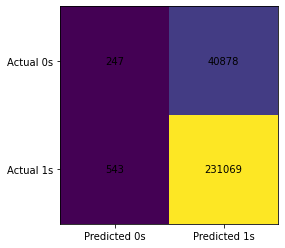

              precision    recall  f1-score   support

           0       0.31      0.01      0.01     41125
           1       0.85      1.00      0.92    231612

    accuracy                           0.85    272737
   macro avg       0.58      0.50      0.46    272737
weighted avg       0.77      0.85      0.78    272737



In [ ]:
print("Result on train data:")
evaluate(my_model, data_folds[fold_idx].train_X, data_folds[fold_idx].train_y)

print("Result on test data:")
evaluate(my_model, data_folds[fold_idx].test_X, data_folds[fold_idx].test_y)